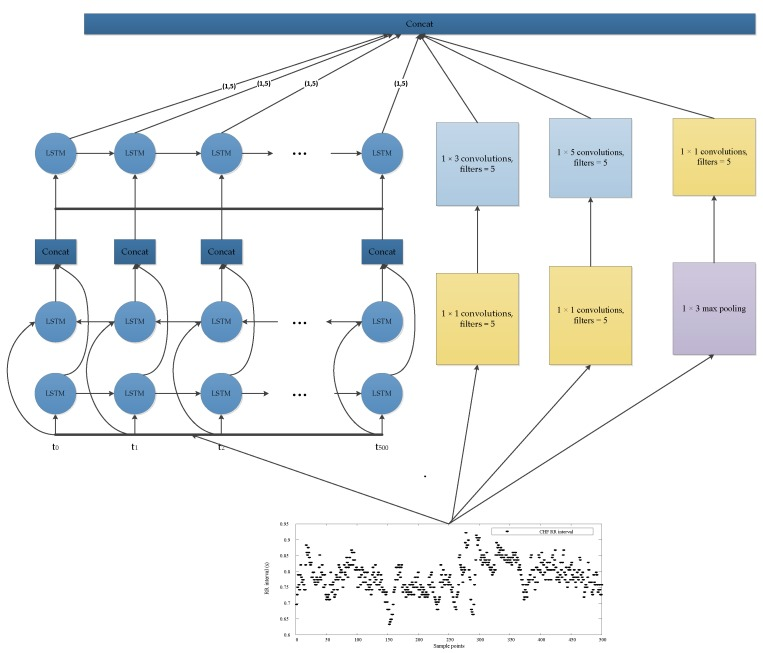

Input is 500 length rr segment from ecg. Above is the model architecture


In [ ]:
!pip install wfdb

     |████████████████████████████████| 143kB 32.4MB/s 


In [ ]:
import wfdb  #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import glob
from sklearn.utils import shuffle

In [ ]:
#downloading the datasets
!wget -r -N -c -np https://physionet.org/files/chfdb/1.0.0/
!wget -r -N -c -np https://physionet.org/files/chf2db/1.0.0/
!wget -r -N -c -np https://physionet.org/files/nsr2db/1.0.0/
!wget -r -N -c -np https://physionet.org/files/fantasia/1.0.0/
!wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/


--2021-07-08 09:10:25--  https://physionet.org/files/chfdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/chfdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]   7.48K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-07-08 09:10:26 (325 MB/s) - ‘physionet.org/files/chfdb/1.0.0/index.html’ saved [7658]

Loading robots.txt; please ignore errors.
--2021-07-08 09:10:26--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2021-07-08 09:10:26 (5.74 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2021-07-08 09:10:26-

In [ ]:
def get_label(file_name,normal):
  #returns the class label of the ecg file 
  h=wfdb.rdheader(file_name[:-4])
  cl=h.comments[0].split(" ")[-1]
  if cl=="I":
    return 1
  elif cl=="II":
    return 2
  elif cl=="III":
    return 3
  elif cl=="III-IV":
    return 3
  if normal==True:
    return 0

In [ ]:
from itertools import islice
def get_features_and_labels(file_names,normal,segment_len=500):
  """ Accepts a list of ecg annotagtion files names and creates a returns a 2D list in which each row 
  contains the rr interval list of a particular ecg file as well as the list of labels (not hf=0,class I =1,class II=2,
  class III=3). Normal refers to the type of dataset i.e chf(=False) or healthy(=True)
  """

  X=[]
  Y=[]
  
  for f in file_names:
    rr=wfdb.ann2rr(f[:-4],"ecg")
    no_of_segments=len(rr)//segment_len
    length_to_split=[500 for i in range(no_of_segments)]
    Inputt = iter(rr)
    Output = [list(islice(Inputt, elem)) for elem in length_to_split]
    label=get_label(f,normal)
    for i in range(len(Output)):
      X.append(Output[i])
      Y.append(label)
  return X,Y

In [ ]:
#getting training data
data1=glob.glob("/content/physionet.org/files/chf2db/1.0.0/*.ecg")
data2=glob.glob("/content/physionet.org/files/chfdb/1.0.0/*.ecg")
data3=glob.glob("/content/physionet.org/files/fantasia/1.0.0/*.ecg")
data4=glob.glob("/content/physionet.org/files/nsr2db/1.0.0/*.ecg")
data5=glob.glob("/content/physionet.org/files/nsrdb/1.0.0/*.ecg")
data=data1+data2+data3+data4+data5
x1,y1=get_features_and_labels(data1,False)
x2,y2=get_features_and_labels(data2,False)
x3,y3=get_features_and_labels(data3,True)
x4,y4=get_features_and_labels(data4,True)
x5,y5=get_features_and_labels(data5,True)
X=x1+x2+x3+x4+x5
Y=y1+y2+y3+y4+y5

In [ ]:
X,Y=shuffle(X,Y)

In [ ]:
#dont_run
fr=int(len(X)*0.7)
X_train,X_test=X[:fr],X[fr:]
Y_train,Y_test=Y[:fr],Y[fr:]

In [ ]:
##the inception lstm block
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

def inception_lstm_module(layer_in):
  conv1=Conv1D(5,1,activation="relu")(layer_in)
  conv1=Conv1D(5,3,activation="relu")(conv1)
  conv2=Conv1D(5,1,activation="relu")(layer_in)
  conv2=Conv1D(5,5,activation="relu")(conv2)
  pool=MaxPooling1D(pool_size=3,strides=3)(layer_in)
  pool=Conv1D(5,1,activation="relu")(pool)
  #layer_out=concatenate([conv1,conv2,pool],axis=-1)

  #lstm module

  ls=Bidirectional(LSTM(10,return_sequences=True),merge_mode="concat")(layer_in)
  ls=LSTM(5,return_sequences=True)(ls)
  layer_out=concatenate([ls,conv1,conv2,pool],axis=1)

  return layer_out


In [ ]:
#BUilding the model

input=Input(shape=(500,1))
layer=inception_lstm_module(input)
layer=inception_lstm_module(layer)
layer=Dropout(0.4)(layer)
layer=Flatten()(layer)
layer=Dense(4)(layer)
layer=Activation("softmax")(layer)
model=Model(inputs=input,outputs=layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 500, 20)      960         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 5)       10          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 5)       10          input_1[0][0]                    
______________________________________________________________________________________________

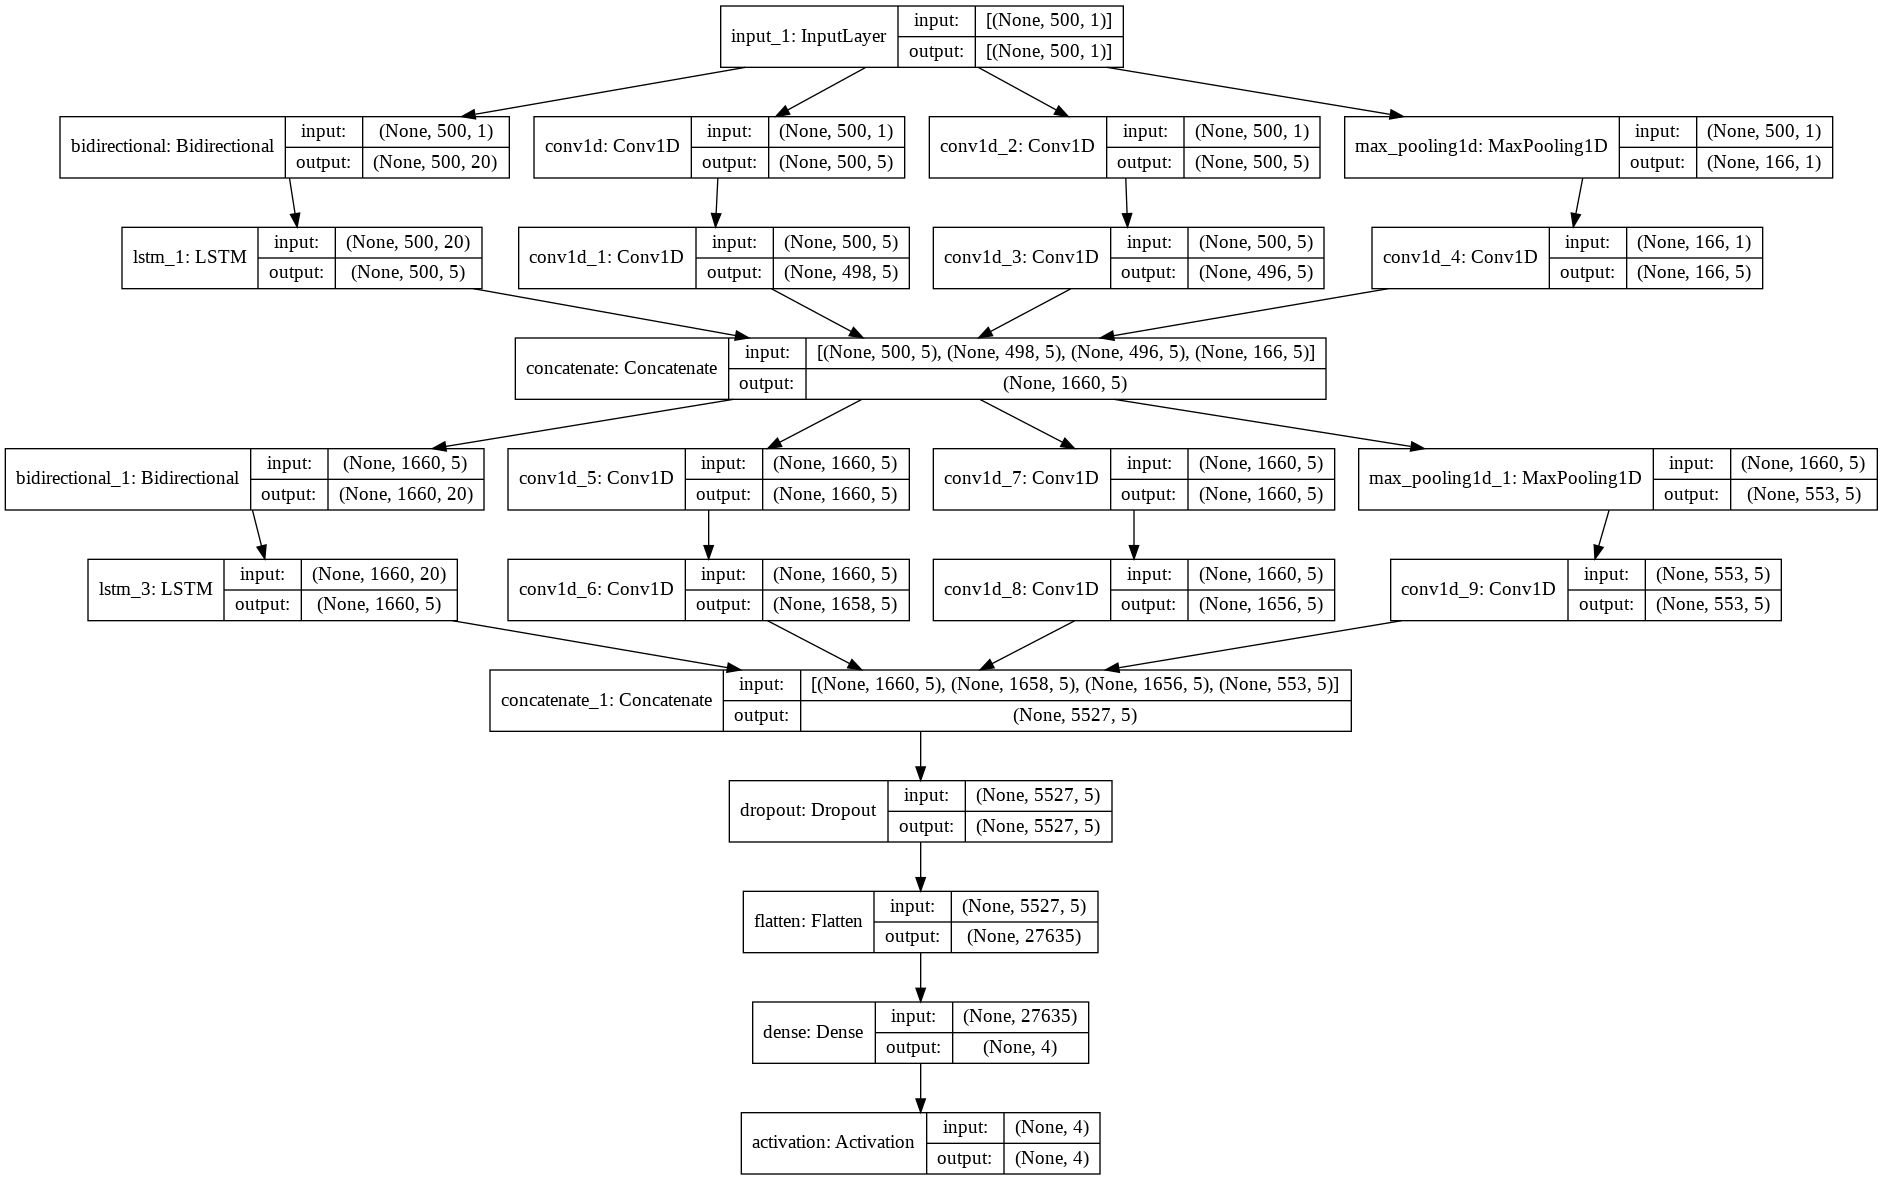

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [ ]:
import tensorflow as tf
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision()])

In [ ]:
Y=tf.keras.utils.to_categorical(Y,num_classes=4)

In [ ]:
history=model.fit(x=np.array(X),y=np.array(Y),epochs=100,validation_split=0.3,shuffle=True)

Epoch 1/100
483/483 [==============================] - 151s 190ms/step - loss: 8.4760 - accuracy: 0.4868 - auc: 0.6872 - precision: 0.4648 - val_loss: 2.1583 - val_accuracy: 0.6242 - val_auc: 0.7681 - val_precision: 0.5462
Epoch 2/100
483/483 [==============================] - 90s 186ms/step - loss: 5.1345 - accuracy: 0.5978 - auc: 0.7849 - precision: 0.5680 - val_loss: 1.4590 - val_accuracy: 0.5678 - val_auc: 0.8038 - val_precision: 0.5951
Epoch 3/100
483/483 [==============================] - 90s 187ms/step - loss: 1.3614 - accuracy: 0.6339 - auc: 0.8084 - precision: 0.6019 - val_loss: 1.0678 - val_accuracy: 0.7148 - val_auc: 0.8233 - val_precision: 0.6275
Epoch 4/100
483/483 [==============================] - 91s 188ms/step - loss: 0.9602 - accuracy: 0.6938 - auc: 0.8294 - precision: 0.6394 - val_loss: 1.3274 - val_accuracy: 0.7089 - val_auc: 0.8387 - val_precision: 0.6562
Epoch 5/100
483/483 [==============================] - 91s 189ms/step - loss: 1.0063 - accuracy: 0.6950 - auc: 

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision'])

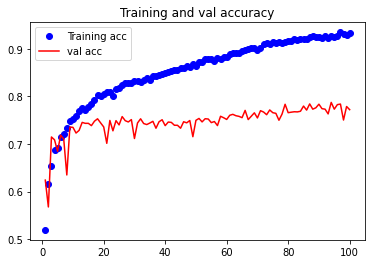

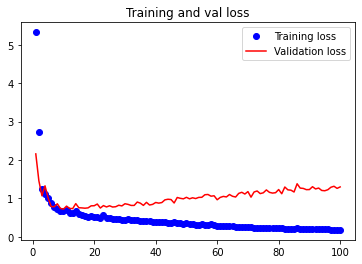

In [ ]:
import matplotlib.pyplot as plt

auc = history.history['auc']
acc = history.history['accuracy']
val_acc=history.history["val_accuracy"]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='val acc')
plt.title('Training and val accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and val loss')
plt.legend()
plt.show()

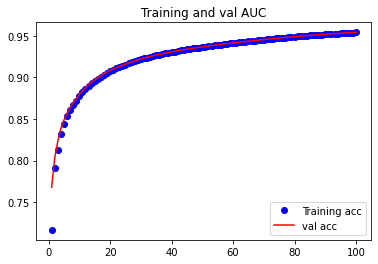

<Figure size 432x288 with 0 Axes>

In [ ]:
val_auc=history.history["val_auc"]
plt.plot(epochs, auc, 'bo', label='Training acc')
plt.plot(epochs, val_auc, 'r', label='val acc')
plt.title('Training and val AUC')
plt.legend()
plt.figure()
plt.show()